# SPTcl-IRAGN $z-M_{500}$ Slope Suite Uncertainty Plot
## Author: Benjamin Floyd

Creates a visualization of how the uncertainties in the redshift--halo mass covariances vary as a function of the input parameter set.

In [7]:
import numpy as np
import h5py
import emcee
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 14})

eta_zeta_pattern = re.compile(r'[ez](-*\d+.\d+|\d+)')

In [8]:
def create_matrices(sampler_dict: dict[emcee.EnsembleSampler]) -> tuple[np.ndarray, np.ndarray]:
    # Build the matrices of uncertainties
    eta_matrix, zeta_matrix = np.zeros(shape=(6, 5)), np.zeros(shape=(6, 5))
    for chain_name, sampler in sampler_dict.items():
        # Extract the parameters from the chain name
        eta, zeta = np.array(eta_zeta_pattern.findall(chain_name), dtype=float)

        # Get the indices of the parameters
        eta_idx = eta_range.index(eta)
        zeta_idx = zeta_range.index(zeta)

        # Get the burn-in and thinning
        nsteps = sampler.iteration
        try:
            # Calculate the autocorrelation time
            tau_est = sampler.get_autocorr_time()
            assert np.isfinite(tau_est).all()

            tau = np.mean(tau_est)

            # Remove the burn-in. We'll use ~3x the autocorrelation time
            burnin = int(3 * tau)

            # We will not thin if we don't have to
            thinning = 1

        except emcee.autocorr.AutocorrError:
            tau_est = sampler.get_autocorr_time(quiet=True)
            tau = np.mean(tau_est)

            burnin = int(nsteps // 3)
            thinning = 1

        except AssertionError:
            tau_est = sampler.get_autocorr_time(quiet=True)
            tau = np.nanmean(tau_est)

            burnin = int(nsteps // 3)
            thinning = 1

        # Get the flattened chain
        flat_samples = sampler.get_chain(discard=burnin, thin=thinning, flat=True)

        # Get the uncertainty measurements
        mcmc_fits = np.percentile(flat_samples[:, 1:3], [16, 50, 84], axis=0)
        eta_uncert, zeta_uncert = np.sqrt(np.diff(mcmc_fits, axis=0).prod(axis=0))

        # Populate the matrices
        eta_matrix[eta_idx, zeta_idx] = eta_uncert
        zeta_matrix[eta_idx, zeta_idx] = zeta_uncert

    return eta_matrix, zeta_matrix

In [9]:
# Read in the chains
filename = 'Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Chains/Port_Rebuild_Tests/eta-zeta_grid/emcee_chains_eta-zeta_grid_308cl_snr13.h5'

# Get a list of the chain runs stored in our file
with h5py.File(filename, 'r') as f:
    chain_names = list(f.keys())

# Load in all samplers from the file
hi_snr_samplers = {chain_name: emcee.backends.HDFBackend(filename, name=chain_name) for chain_name in chain_names}

In [10]:
# Set the range of parameters used
eta_range = [-5., -3., 0., 3., 4., 5.]
zeta_range = [-2., -1., 0., 1., 2.]

In [11]:
# Create the matrices
hi_snr_eta_matrix, hi_snr_zeta_matrix = create_matrices(hi_snr_samplers)

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [171.89988188 228.28999851 194.82179049 114.61949085 138.37044855
 130.01137255]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [232.9966179  149.39164347 214.98220392  48.18847715 109.63237038
  42.55519797]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [183.46461628 189.18042574 145.00599259  36.96694466 135.84074758
  36.15506057]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [139.8073496   27.32165469  89.1562916   67.26517987  25.35754312
  32.94106616]
The chain is shorter tha

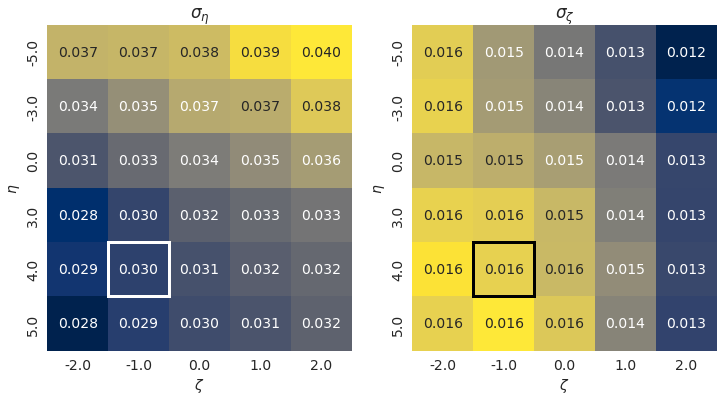

In [19]:
# Plot the matrices
fig, (ax_eta, ax_zeta) = plt.subplots(ncols=2, figsize=(12, 6))
sns.heatmap(hi_snr_eta_matrix, annot=True, fmt='.3f', ax=ax_eta, yticklabels=eta_range, xticklabels=zeta_range, cbar=False, cmap='cividis')
sns.heatmap(hi_snr_zeta_matrix, annot=True, fmt='.3f', ax=ax_zeta, yticklabels=eta_range, xticklabels=zeta_range, cbar=False, cmap='cividis')
ax_eta.add_patch(Rectangle((1, 4), 1, 1, fill=False, edgecolor='w', lw=3))
ax_zeta.add_patch(Rectangle((1, 4), 1, 1, fill=False, edgecolor='k', lw=3))
ax_eta.set(title=r'$\sigma_\eta$', ylabel=r'$\eta$', xlabel=r'$\zeta$')
ax_zeta.set(title=r'$\sigma_\zeta$', ylabel=r'$\eta$', xlabel=r'$\zeta$')
plt.show()